<a href="https://colab.research.google.com/github/lilanpei/NMT/blob/master/NMT_Bi_GRU_%2B_Attention_%2B_pre_trained_Fasttext_word_embedding_%2B_k_Beam_search_%2B_BLEU_score_Microblog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tokenizing:

In [ ]:
# from nltk.parse import CoreNLPParser
# parser = CoreNLPParser('http://localhost:9001')
# with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
#     with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
#         for _ , line in enumerate(f):
#             cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [ ]:
# from nltk.parse import CoreNLPParser
# parser = CoreNLPParser('http://localhost:9001')
# with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
#     with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
#         for _ , line in enumerate(f):
#             cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!/opt/bin/nvidia-smi

Thu Jun 18 23:03:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    31W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# For easy reset of notebook state.
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
tf.keras.backend.clear_session()

config_proto = tf.compat.v1.ConfigProto()
off = rewriter_config_pb2.RewriterConfig.OFF
config_proto.graph_options.rewrite_options.arithmetic_optimization = off
session = tf.compat.v1.Session(config=config_proto)
tf.compat.v1.keras.backend.set_session(session)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [ ]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [ ]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang, num_words):
    lang_tokenizer = T.Tokenizer(num_words=num_words,filters='', oov_token='<UNK>')
    lang_tokenizer.fit_on_texts(lang)
    lang_tokenizer.word_index = {e:i for e,i in lang_tokenizer.word_index.items() if i <= lang_tokenizer.num_words}
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

Using TensorFlow backend.


In [ ]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None, num_words=80000):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang, num_words*2 if num_words else None)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang, num_words)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
path_to_file_zh = r'/content/drive/My Drive/NLP/NMT/Bi-Microblog_zh.tok'
path_to_file_en = r'/content/drive/My Drive/NLP/NMT/Bi-Microblog_en.tok'

# Try experimenting with the size of that dataset
#num_examples = 450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en)#, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [ ]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 13756, 11113


In [ ]:
from gensim.models import FastText

vector_size = 100
inps, targs  = create_dataset(path_to_file_zh, path_to_file_en)
tokens_zh = [[token for token in sents.split()] for sents in inps]
tokens_en = [[token for token in sents.split()] for sents in targs]
fast_model_zh = FastText(tokens_zh, size=vector_size, window=10, min_count=5, sg=1, iter=20, negative=10)
fast_model_en = FastText(tokens_en, size=vector_size, window=10, min_count=5, sg=1, iter=20, negative=10)

In [ ]:
import numpy as np

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(fast_model, word2index, vector_size, num_tokens):
    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))
    
    for word, idx in word2index.items():
        try:
          word_vec = fast_model.wv.word_vec(word)
        except KeyError:
          print('Can not find word_vec', word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(fast_model_zh, inp_lang.word_index, vector_size, num_encoder_tokens)
output_emb_matrix = get_embedding_matrix(fast_model_en, targ_lang.word_index, vector_size, num_decoder_tokens)

# Save output embedding vectors
np.save(r'/content/drive/My Drive/NLP/input_emb_matrix', input_emb_matrix)
np.save(r'/content/drive/My Drive/NLP/output_emb_matrix', output_emb_matrix)

In [ ]:
import numpy as np

# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(trained_vector_path, word2index, vector_size, num_tokens):
    trained_word_vec = word2vec(trained_vector_path)
    print('number of trained word vector: {}:{}'.format(trained_vector_path, len(trained_word_vec)))

    embedding_matrix = np.random.uniform(-0.2, 0.2, (num_tokens, vector_size))

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
import numpy as np

vector_size = 300
trained_vector_paths = (r'/content/drive/My Drive/NLP/cc.zh.300.vec', r'/content/drive/My Drive/NLP/cc.en.300.vec')

# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(trained_vector_paths[0], inp_lang.word_index, vector_size, num_encoder_tokens)
output_emb_matrix = get_embedding_matrix(trained_vector_paths[1], targ_lang.word_index, vector_size, num_decoder_tokens)
# Save output embedding vectors
np.save(r'/content/drive/My Drive/NLP/input_emb_matrix_Microblog', input_emb_matrix)
np.save(r'/content/drive/My Drive/NLP/output_emb_matrix_Microblog', output_emb_matrix)

In [ ]:
import numpy as np
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'/content/drive/My Drive/NLP/NMT/input_emb_matrix_Microblog.npy'), np.load(r'/content/drive/My Drive/NLP/NMT/output_emb_matrix_Microblog.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (13756, 300), (11113, 300)


In [ ]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 4000, 1000


In [ ]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
#max_length_inp = max_length_targ = 30
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 85, 81


In [ ]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size):
    while True:
        cnt = (len(input_tensor)//batch_size)*batch_size
        for i in range(0, min(len(input_tensor),cnt), batch_size):
            encoder_input_batch = input_tensor[i:i + batch_size]
            encoder_input_batch = S.pad_sequences(encoder_input_batch,padding='post', maxlen = max_length_inp, truncating='post')
            decoder_input_batch = target_tensor[i:i + batch_size]
            decoder_input_batch = S.pad_sequences([s[:-1] for s in decoder_input_batch],padding='post', maxlen = max_length_targ, truncating='post')
            decoder_target_batch = target_tensor[i:i + batch_size]
            decoder_target_batch = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in decoder_target_batch],padding='post', maxlen = max_length_targ, truncating='post')])
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

batch_size = 32
latent_dim = 300
# Set up the encoder
encoder_inputs = Input(batch_shape=(batch_size, max_length_inp,))
enc_emb_layer =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
print(encoder_inputs.shape, enc_emb.shape)
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

(32, 85) (32, 85, 300)


In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(batch_shape=(batch_size, max_length_targ,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
print(decoder_inputs.shape, dec_emb.shape)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder GRU output
print(decoder_outputs.shape,attn_out.shape)
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# Dense layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')
decoder_outputs = dense_time(decoder_concat_input)

(32, 81) (32, 81, 300)
(32, 81, 600) (32, 81, 600)


In [ ]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 85)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (32, 85, 300)        4126800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 81)]           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(32, 85, 600), (32, 1083600     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


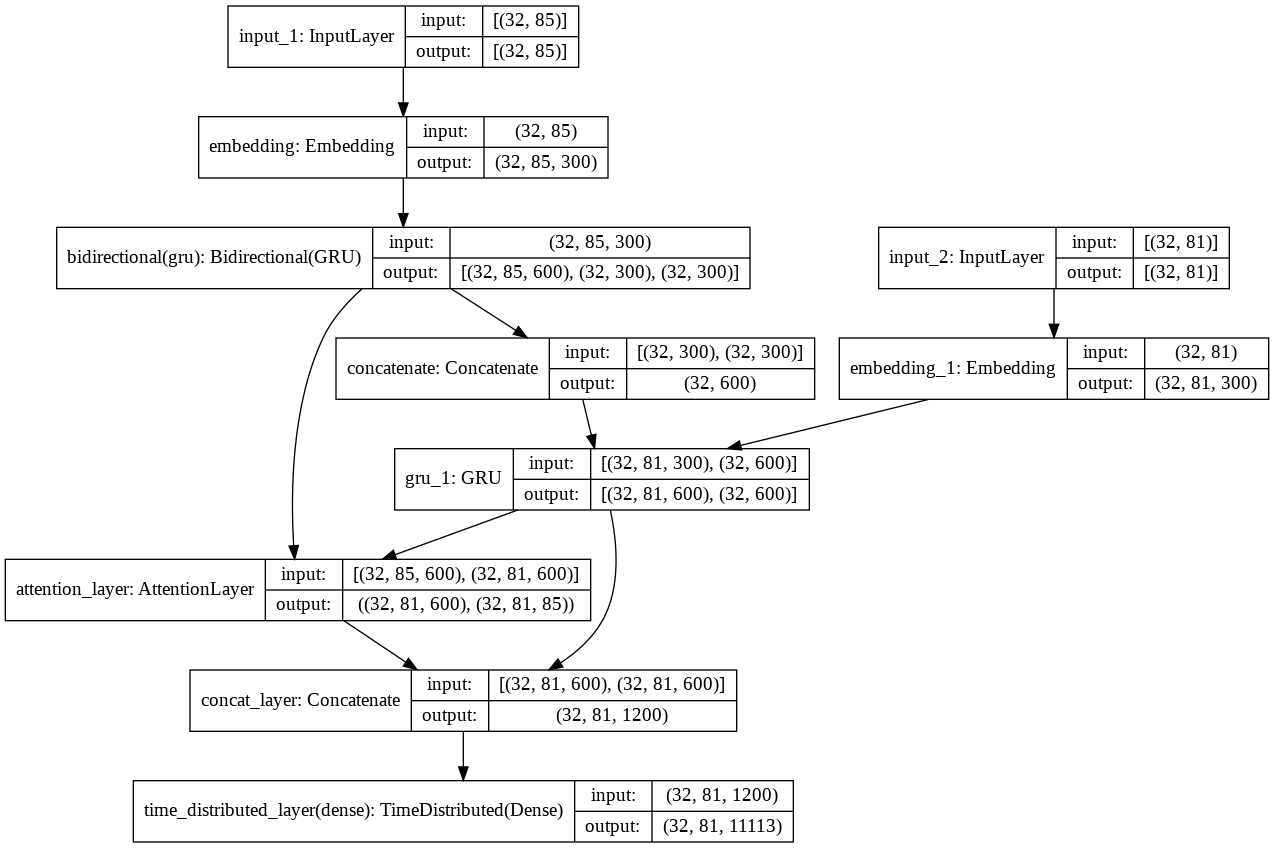

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [ ]:
# Start training
epochs = 50
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
125/125 [==============================] - 100s 801ms/step - loss: 2.1202 - acc: 0.7332 - val_loss: 1.7669 - val_acc: 0.7550
Epoch 2/50
125/125 [==============================] - 100s 797ms/step - loss: 1.6861 - acc: 0.7538 - val_loss: 1.6819 - val_acc: 0.7616
Epoch 3/50
125/125 [==============================] - 99s 793ms/step - loss: 1.5681 - acc: 0.7602 - val_loss: 1.6363 - val_acc: 0.7661
Epoch 4/50
125/125 [==============================] - 99s 795ms/step - loss: 1.4792 - acc: 0.7639 - val_loss: 1.6223 - val_acc: 0.7679
Epoch 5/50
125/125 [==============================] - 99s 795ms/step - loss: 1.3926 - acc: 0.7676 - val_loss: 1.6158 - val_acc: 0.7696
Epoch 6/50
125/125 [==============================] - 99s 794ms/step - loss: 1.3077 - acc: 0.7713 - val_loss: 1.6081 - val_acc: 0.7719
Epoch 7/50
125/125 [==============================] - 99s 796ms/step - loss: 1.2224 - acc: 0.7761 - val_loss: 1.

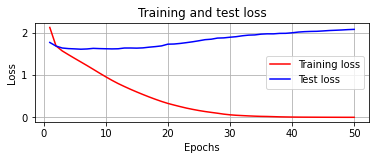

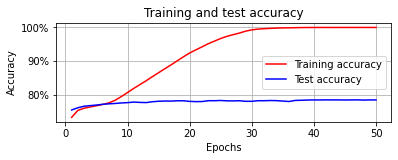

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
# Inference model
batch_size = 1

# Encoder (Inference) model
encoder_inf_inputs = Input(batch_shape=(batch_size, max_length_inp,), name='encoder_inf_inputs')
enc_inf_emb = enc_emb_layer(encoder_inf_inputs)
# Encode the input sequence to get the "Context vectors"
encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state = encoder_gru(enc_inf_emb)
encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_fwd_state, encoder_inf_back_state])

# Decoder (Inference) model
decoder_inf_inputs = Input(batch_shape=(batch_size, 1,), name='decoder_word_inputs')
encoder_inf_outputs = Input(batch_shape=(batch_size, max_length_inp, 2*latent_dim), name='encoder_inf_outputs')
decoder_init_state = Input(batch_shape=(batch_size, 2*latent_dim), name='decoder_init')
# Get the embeddings of the decoder sequence
dec_inf_emb= dec_emb_layer(decoder_inf_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_inf_out, decoder_inf_state = decoder_gru(dec_inf_emb, initial_state=decoder_init_state)
attn_inf_out, attn_inf_states = attn_layer([encoder_inf_outputs, decoder_inf_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_inf_pred = TimeDistributed(decoder_dense)(decoder_inf_concat)
# Final decoder model
decoder_model = Model(inputs=[encoder_inf_outputs, decoder_init_state, decoder_inf_inputs],
                        outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

In [ ]:
# Encoder model summary
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inf_inputs (InputLay [(1, 85)]                 0         
_________________________________________________________________
embedding (Embedding)        multiple                  4126800   
_________________________________________________________________
bidirectional (Bidirectional multiple                  1083600   
Total params: 5,210,400
Trainable params: 1,083,600
Non-trainable params: 4,126,800
_________________________________________________________________


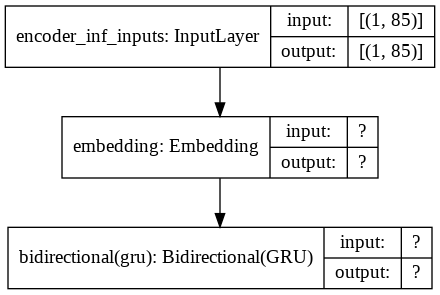

In [ ]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [ ]:
# Decoder model summary
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_word_inputs (InputLayer [(1, 1)]             0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             3333900     decoder_word_inputs[0][0]        
__________________________________________________________________________________________________
decoder_init (InputLayer)       [(1, 600)]           0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     multiple             1623600     embedding_1[1][0]                
                                                                 decoder_init[0][0]         

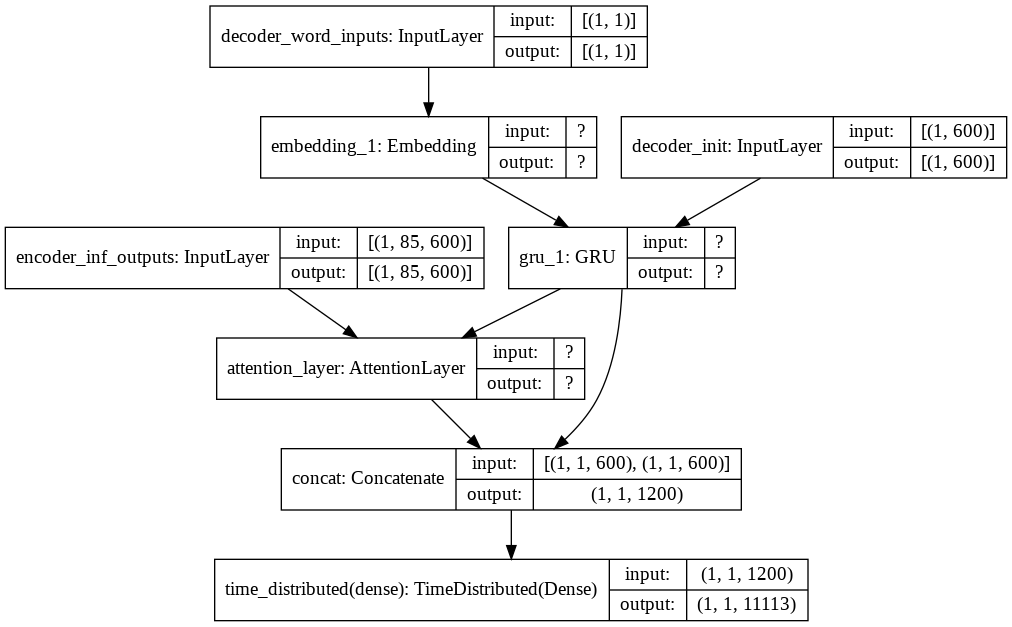

In [ ]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [ ]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    enc_outs, enc_fwd_state, enc_back_state = encoder_model.predict(input_seq)
    states_value = np.concatenate([enc_fwd_state, enc_back_state], axis=-1)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = targ_lang.word_index['<start>']
    output, attent, states = decoder_model.predict([enc_outs, states_value, target_seq])
    sampled_token_index =  np.argsort(-output[0, -1, :])
    candidates = list()
    for idx in sampled_token_index[:k]:
        candidates.append([[idx], [[idx, attent]], [states], -np.log(output[0, -1, idx])])
    for l in range(max_length_targ):
        all_candidates = list()
        for i in range(len(candidates)):
            seq, atten, stas, score = candidates[i]
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = seq[-1]
            output_tokens, attention, states_value = decoder_model.predict([enc_outs, stas[-1], target_seq])
            sampled_token_indices =  np.argsort(-output_tokens[0, -1, :])
            for index in sampled_token_indices[:k]:
                candidate = [seq + [index], atten + [[index, attention]], stas + [states_value], score - np.log(output_tokens[0, -1, index])]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda item:item[-1])
        candidates = ordered[:k]
        if candidates[0][0][-1] == targ_lang.word_index['<end>']:
            break
    return candidates

In [ ]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [ ]:
!wget "https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip"
!unzip "simhei.zip"
!mv SimHei.ttf /content

--2020-06-18 23:33:11--  https://www.wfonts.com/download/data/2014/06/01/simhei/simhei.zip
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546298 (10M) [application/octetstream]
Saving to: ‘simhei.zip’

simhei.zip          100%[===================>]  10.06M  23.0MB/s    in 0.4s    

2020-06-18 23:33:12 (23.0 MB/s) - ‘simhei.zip’ saved [10546298/10546298]

Archive:  simhei.zip
  inflating: chinese.simhei.ttf      
  inflating: SimHei.ttf              
  inflating: sharefonts.net.txt      
mv: 'SimHei.ttf' and '/content/SimHei.ttf' are the same file


In [ ]:
import os
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.font_manager as fm
path = '//content/SimHei.ttf'
fontprop = fm.FontProperties(fname=path, size=10)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

def plot_attention_weights(encoder_inputs, attention_weights, index_word_inp, index_word_targ, base_dir, filename=None):
    """
    Plots attention weights
    :param encoder_inputs: Sequence of word ids (list/numpy.ndarray)
    :param attention_weights: Sequence of (<word_id_at_decode_step_t>:<attention_weights_at_decode_step_t>)
    :param en_id2word: dict
    :param fr_id2word: dict
    :return:
    """

    if len(attention_weights) == 0:
        print('Your attention weights was empty. No attention map saved to the disk. ' +
              '\nPlease check if the decoder produced  a proper translation')
        return

    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn.reshape(-1))
        dec_inputs.append(dec_ind)
        #print(len(attention_weights))
    attention_mat = np.transpose(np.array(mats))
    #print(attention_mat.shape)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(attention_mat[:len(trim_zeros(encoder_inputs.ravel())),:])
    ax.set_xticks(np.arange(len(trim_zeros(dec_inputs))))
    ax.set_yticks(np.arange(len(trim_zeros(encoder_inputs.ravel()))))

    ax.set_yticklabels([index_word_inp[inp] for inp in trim_zeros(encoder_inputs.ravel())],fontproperties=fontprop)
    ax.set_xticklabels([index_word_targ[inp] for inp in trim_zeros(dec_inputs)])

    ax.tick_params(labelsize=24)
    ax.tick_params(axis='x', labelrotation=90)

    if not os.path.exists(os.path.join(base_dir, 'results')):
        os.mkdir(os.path.join(base_dir, 'results'))
    if filename is None:
        plt.savefig(os.path.join(base_dir, 'results', 'attention.png'))
    else:
        plt.savefig(os.path.join(base_dir, 'results', '{}'.format(filename)))

In [ ]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

Input Source sentence: 有时候 你 不得不 放弃 一 个 人 ， 不 是 因为 你 不 在乎 ， 而 是 因为 他们 不在乎 。
Actual   Target  Translation: sometimes , you have to give up on people , not because you don t care , because they don t .
Predicted Target Translation: sometimes , you have to give up on people , not because you don t care , because they don t .


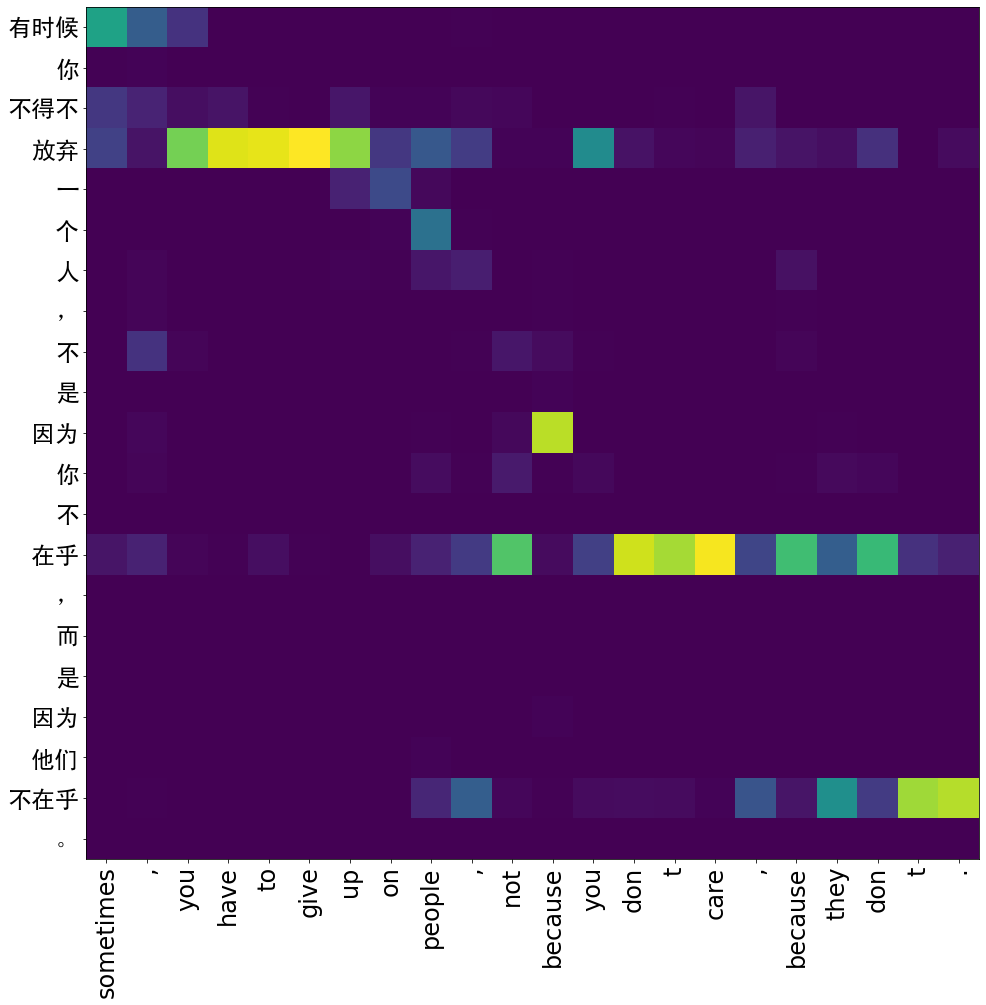

In [ ]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
candidates = decode_sequence_with_k_beam_search(input_seq, 3)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual   Target  Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
score = sentence_bleu(reference, test)
print('Test - Predicted Target Translation:', test)
print('Reference - Actual Target Translation:', reference)
print('Bleu score:',score)

Test - Predicted Target Translation: ['sometimes', ',', 'you', 'have', 'to', 'give', 'up', 'on', 'people', ',', 'not', 'because', 'you', 'don', 't', 'care', ',', 'because', 'they', 'don', 't', '.']
Reference - Actual Target Translation: [['sometimes', ',', 'you', 'have', 'to', 'give', 'up', 'on', 'people', ',', 'not', 'because', 'you', 'don', 't', 'care', ',', 'because', 'they', 'don', 't', '.']]
Bleu score: 1.0


In [ ]:
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)
N_samples = train_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(train_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

Sample: 0 in total number of 4000

Input Source sentence: 有时候 你 不得不 放弃 一 个 人 ， 不 是 因为 你 不 在乎 ， 而 是 因为 他们 不在乎 。
Actual Target Translation: sometimes , you have to give up on people , not because you don t care , because they don t .
Predicted Target Translation: sometimes , you have to give up on people , not because you don t care , because they don t .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 4000

Input Source sentence: 健康 为最 好 的 天赋 ， 知足 为 最 大 的 财富 ， 信任 为 最 佳 的 品德 。
Actual Target Translation: sound heath is the greatest of gifts , contentedness , the greatest of riches , trust , the greatest of qualities .
Predicted Target Translation: sound heath is the greatest of gifts , contentedness , the greatest of riches , trust , the greatest of qualities .
Bleu score: 1.0
------------------------------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。
-------------------------------------------------------------------------------------------------------------------------
Sample: 223 in total number of 4000

Input Source sentence: 谁 言 寸草 心 ， 报 得 三 春晖 ？
Actual Target Translation: such kindness as young grass receives from the warm sun can t be repaid .
Predicted Target Translation: such kindness as young grass receives from the warm sun can t be repaid .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 224 in total number of 4000

Input Source sentence: 我 只 想 找 一 个 真心 理解 我 ， 爱 我 的 ta 度过 我 的 一 生 ， 否则 我 宁愿 独自 一 个 人
Actual Target Translation: i just want to be with the one who really understands and loves me from the heart , or i d rather be alone .
Predicted Target Translation: i just want to be with the one who really understands and loves me from the heart , or i d rather be alone .
Bleu score: 1.0
--------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。

Input Source sentence: 如果 你 问 我 ， 我 会 想要 回到 过去 的 任何 一 天 。 不为 追悔 ， 只为 重温 我们 难忘 的 回忆 。
Actual Target Translation: if you asked me , i would go back to any day in the past. not to fix my regrets , but to relive all our unforgettable memories .
Predicted Target Translation: if you asked me , i would go back to any day in the past. not to fix my regrets , but to relive all our unforgettable memories .
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 3287 in total number of 4000

Input Source sentence: 伊拉克 巴格达 发生 炸弹 袭击 至少 31 人 死亡 60 人 受伤
Actual Target Translation: suicide car bomb attack kills 31 , injures 60 in iraqi capital
Predicted Target Translation: suicide car bomb attack kills 31 , injures 60 in iraqi capital
Bleu score: 1.0
-------------------------------------------------------------------------------------------------------------------------
Sample: 3288 in 

In [ ]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

Input Source sentence: 你 越 早 接受 现实 ， 就 会 有 越 大 的 机遇 在 等待 你 你 越 早 接受 这个 事实 ， 就 能越 早 踏入 新 生活 。
Actual Target Translation: the earlier you enter the real world , the greater opportunities you will achieve the sooner you accept the truth , the sooner you will step into new life .
Predicted Target Translation: you are the opportunities why you want to be a great life , you have to go through the life .


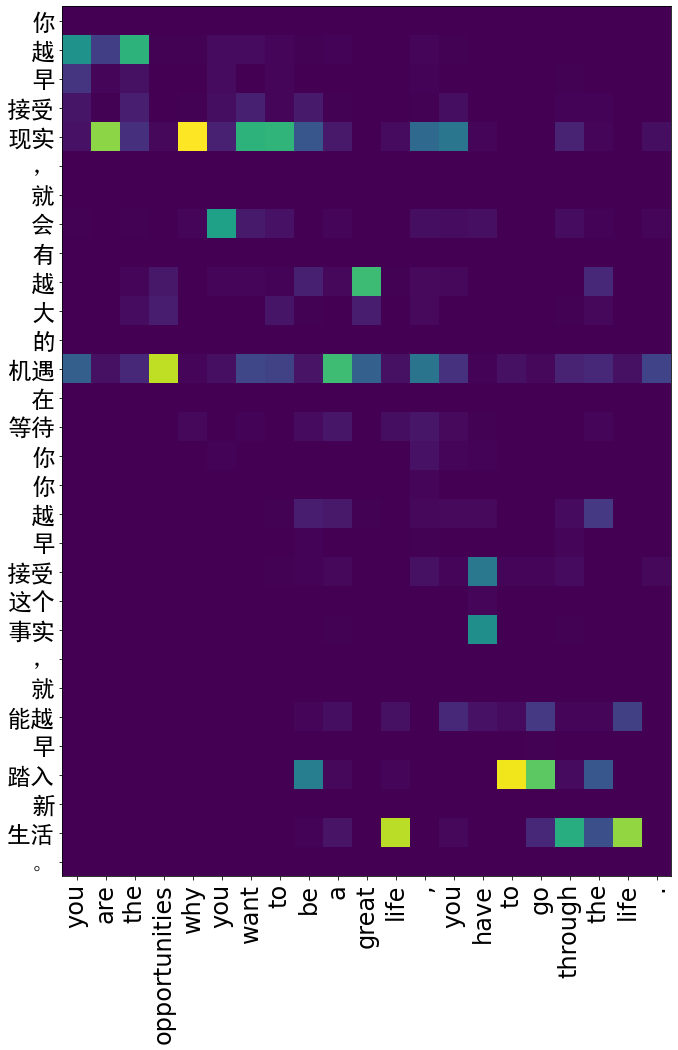

In [ ]:
(input_seq, actual_output), _ = next(test_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [ ]:
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)
N_samples = val_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(test_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 1000

Input Source sentence: 你 越 早 接受 现实 ， 就 会 有 越 大 的 机遇 在 等待 你 你 越 早 接受 这个 事实 ， 就 能越 早 踏入 新 生活 。
Actual Target Translation: the earlier you enter the real world , the greater opportunities you will achieve the sooner you accept the truth , the sooner you will step into new life .
Predicted Target Translation: you are the opportunities why you want to be a great life , you have to go through the life .
Bleu score: 0.24924249970265266
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 1000

Input Source sentence: 在 美国 ， 50 的 宠物 主将 宠物 视为 完整 家庭 成员 ， 43 的 宠物主 用人 粮 喂养 宠物 。 请看 voa 专题 报道
Actual Target Translation: in the u.s. , 50 of pet owners consider their pets to be full members of the family . and 43 feed the animals people food .
Predicted Target Translation: with u.s. would not be happy to have a good or by the u.s. and free to work with how to participate i

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 2 in total number of 1000

Input Source sentence: 靠 。 什么 原因 导致 的 啊 ？ rt torijwatson 暴乱 ， 打砸抢 ， 蓄意 袭击 记者 ， 民宅 商店 纵火 。
Actual Target Translation: shit. what started it ? rt torijwatson random rioting looting mugging , journalists being purposefully attacked , homes shops on fire .
Predicted Target Translation: the chief do not in the office to save in ... some of the u.s. check at last , and then it s profitable to have found out .
Bleu score: 0.5671276403520978
-------------------------------------------------------------------------------------------------------------------------
Sample: 3 in total number of 1000

Input Source sentence: 宁愿 保持 沉默 让 人 看起来 像 个 傻子 ， 也 不 要 一 开口 就 证明 自己 确实 如此
Actual Target Translation: it is better to stay silent and be thought a fool , than to open one s mouth and remove all doubt .
Predicted Target Translation: if two people who can not so there is they can holding it can t be afraid again .
Bleu score: 0.5487773527367232
--------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


流式输出内容被截断，只能显示最后 5000 行内容。

Input Source sentence: 明天 一早 要 去 济南 录 山东 卫视 的 一 档 新 节目 ， 济南 有 没 有 好玩 的 地方 呢
Actual Target Translation: tomorrow morning i ll be going to jinan to record a new shandong tv program , anything fun places in jinan ?
Predicted Target Translation: tomorrow , leaving back to the national plan for a while a zach educating a sword. where will be a fun ! !
Bleu score: 0.7146704964214272
-------------------------------------------------------------------------------------------------------------------------
Sample: 287 in total number of 1000

Input Source sentence: 孩子 害怕 黑暗 ， 情有可原 人生 真正 的 悲剧 ， 是 成人 害怕 光明 。 柏拉图 ， 古希腊 哲学家 ， 公元前 428 前 348
Actual Target Translation: we can easily forgive a child who is afraid of the dark the real tragedy of life is when men are afraid of the light. plato , ancient greek philosopher , 428 bc 348 bc
Predicted Target Translation: the man is not thin , which has a weak , and when the man is the prince , the source of the beginning , as a ligh

In [ ]:
path_to_file_zh = r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Testing-Data_zh.tok'
path_to_file_en = r'/content/drive/My Drive/NLP/UM-Corpus/tokens/Testing-Data_en.tok'

# Try experimenting with the size of that dataset
#num_examples = 450000
input_tensor_ts, target_tensor_ts = create_dataset(path_to_file_zh, path_to_file_en)
input_tensor_ts, target_tensor_ts = inp_lang.texts_to_sequences(input_tensor_ts[4934:]), targ_lang.texts_to_sequences(target_tensor_ts[4934:])
# Number of Training/Testing samples
tr_samples = len(input_tensor)
ts_samples = len(input_tensor_ts)
print('Number of samples for Training/Testing: {}, {}'.format(tr_samples, ts_samples))

Number of samples for Training/Testing: 5000, 66


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 85)]           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (32, 85, 300)        4126800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(32, 81)]           0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(32, 85, 600), (32, 1083600     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
# Start training
batch_size = 32
epochs = 32
history = model.fit_generator(generator = generate_batch(input_tensor, target_tensor, batch_size = batch_size),
                    steps_per_epoch = tr_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = batch_size),
                    validation_steps = ts_samples//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/32
156/156 [==============================] - 49s 314ms/step - loss: 2.0518 - acc: 0.7375 - val_loss: 1.2912 - val_acc: 0.7978
Epoch 2/32
156/156 [==============================] - 48s 306ms/step - loss: 1.6427 - acc: 0.7574 - val_loss: 1.1915 - val_acc: 0.8094
Epoch 3/32
156/156 [==============================] - 48s 307ms/step - loss: 1.5396 - acc: 0.7635 - val_loss: 1.1530 - val_acc: 0.8115
Epoch 4/32
156/156 [==============================] - 48s 308ms/step - loss: 1.4411 - acc: 0.7678 - val_loss: 1.1259 - val_acc: 0.8144
Epoch 5/32
156/156 [==============================] - 48s 307ms/step - loss: 1.3511 - acc: 0.7712 - val_loss: 1.0918 - val_acc: 0.8187
Epoch 6/32
156/156 [==============================] - 48s 308ms/step - loss: 1.2520 - acc: 0.7759 - val_loss: 1.0689 - val_acc: 0.8198
Epoch 7/32
156/156 [==============================] - 48s 306ms/step - loss: 1.1958 - acc: 0.7792 - val_loss: 1.05

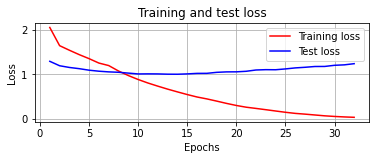

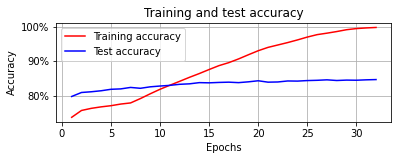

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
# Make predictions on the Test dataset
ts_gen = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = 1)

Input Source sentence: 人生 不 是 要 按 别人 的 想法 <UNK> ， 而是 要 跟随 内心 ， 做 自己 想 做 的 那个 人 。
Actual Target Translation: your life is not about what people expect you to be . it s about following your heart to be what you want to be .
Predicted Target Translation: life isn t always perfect. people who want to be experienced , they have another heart .


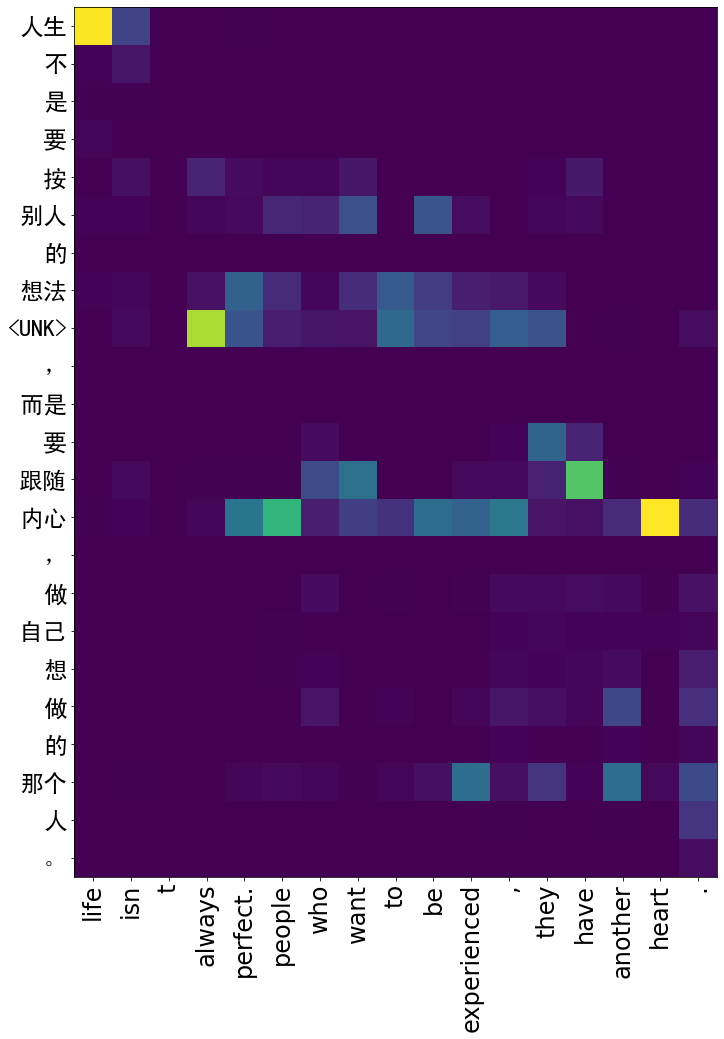

In [ ]:
(input_seq, actual_output), _ = next(ts_gen)
candidates = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
# Attention plotting
plot_attention_weights(input_seq, candidates[0][1][:-1], index_word_inp, index_word_targ, base_dir=r"/content/drive/My Drive/NLP/NMT", filename='attention_{}.png'.format(sequence_to_text(index_word_targ, candidates[0][0][:-1])[0:10]))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
ts_gen = generate_batch(input_tensor_ts, target_tensor_ts, batch_size = 1)
N_samples = ts_samples
scores = [0]*N_samples
for i in range(N_samples):
    (input_seq, actual_output), _ = next(ts_gen)
    candidates = decode_sequence_with_k_beam_search(input_seq)
    reference = [[token for token in sequence_to_text(index_word_targ, actual_output[0][1:].tolist()).split()]]
    test = [token for token in sequence_to_text(index_word_targ, candidates[0][0][:-1]).split()]
    scores[i] = sentence_bleu(reference, test)
    print('Sample: {} in total number of {}\n'.format(i, N_samples))
    print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
    print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
    print('Predicted Target Translation:', sequence_to_text(index_word_targ, candidates[0][0][:-1]))
    print('Bleu score:',scores[i])
    print("-------------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------------")
print("Average Bleu score: {}/{} = {}".format(sum(scores),N_samples,sum(scores)/N_samples))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 0 in total number of 66

Input Source sentence: <UNK> <UNK> 的 时候 ， 总 会 有 人 把 房间 的 <UNK> 悄悄 地 关上 。
Actual Target Translation: when suddenly from the cool breeze , there is always someone put the room quietly shut the <UNK> and windows .
Predicted Target Translation: with someone attempting like the person , get to get an awesome person to get him .
Bleu score: 0.550447407433165
-------------------------------------------------------------------------------------------------------------------------
Sample: 1 in total number of 66

Input Source sentence: 些 似 小 非 小 ， 看轻 非 轻 的 点点滴滴 却 都 源于 一 个 不 变 的 <UNK> ， 那 就 是 亲情 。
Actual Target Translation: these seem small non small , underestimate the importance of non light none <UNK> from a constant mind , it is affection .
Predicted Target Translation: a lot of people think which which has not so many people , and you are the same person who is the only .
Bleu score: 0.7071067811865476
--------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 3 in total number of 66

Input Source sentence: 人生 不 是 要 按 别人 的 想法 <UNK> ， 而是 要 跟随 内心 ， 做 自己 想 做 的 那个 人 。
Actual Target Translation: your life is not about what people expect you to be . it s about following your heart to be what you want to be .
Predicted Target Translation: life isn t always perfect. people who want to be experienced , they have another heart .
Bleu score: 0.1425431526999185
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Sample: 4 in total number of 66

Input Source sentence: 微笑 ， 不 是 因为 快乐 太 久 ， 是 太 久 的 时间 里 忘记 去 悲伤 。
Actual Target Translation: smiling , not because happiness too long , is too long time forgot to sorrow .
Predicted Target Translation: smile , doesn t mean the long time , the long time is long the long .
Bleu score: 0.4005274484725572
-------------------------------------------------------------------------------------------------------------------------
Sample: 5 in total number of 66

Input Source sentence: 有时候 ， 我们 做 过 的 最 艰难 的 选择 ， 最终 成 了 我们 为 自己 做 过 的 最 棒 的 事 。
Actual Target Translation: sometimes the hardest choices we make end up being the best thing we could have ever done for ourselves .
Predicted Target Translation: sometimes , we have the most thing to be the best most ever we are in the way .
Bleu score: 0.39231586328589263
-------------------------------------------------------------------------------------------------------------------------
Sample: 6 in total number of 6